# OST - DATA PREPROCESSING EXTENSION

We will be using Jupyter notebook to preprocess captured data by OST main application for final analysis

### Import and Install Dependacies

We will be using following dependencies to achieve clean dataset

-**Pandas** - For dataset manipulation

In [14]:
# Install necessary libraries
!pip install pandas numpy scipy scikit-learn seaborn ipywidgets

  Using cached ipywidgets-8.1.8-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.15-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl (914 kB)
Using cached widgetsnbextension-4.0.15-py3-none-any.whl (2.2 MB)


In [15]:
# For smoothing
from scipy.signal import find_peaks, medfilt


# For array manipulation
import numpy as np

# Pandas for data manipulation
import pandas as pd

# Math
import math

# For visualization
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display

## Data PreProcessing

In [5]:
# ------------ Load -----------------------
df = pd.read_csv("data/raw_joints.csv")

# ---- SAFE TIMESTAMP PARSING FOR ISO STRINGS ----
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

if df['timestamp'].isna().all():
    raise RuntimeError("All timestamps became NaT. Check input formatting.")

# convert datetime → float seconds
df['timestamp'] = df['timestamp'].astype('int64') / 1e9

FPS = 15.0
df["time"] = np.arange(len(df)) / FPS

# Detect joint columns
joint_cols = [c for c in df.columns if c.startswith("joint_") and c.endswith(("_x","_y","_z"))]
joint_cols = sorted(joint_cols)

raw = df[joint_cols].copy()

# ------------ Interpolate small gaps only --------------
MAX_GAP = 3

interp = raw.interpolate(
    method="linear",
    limit=MAX_GAP,
    limit_direction="both"
)

# ------------ One-Euro Filter --------------------------
class OneEuroFilter:
    def __init__(self, freq, min_cutoff=0.5, beta=0.05, d_cutoff=1.0):
        self.freq = freq
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.d_cutoff = d_cutoff
        self.last_value = None
        self.last_derivative = 0
    
    def alpha(self, cutoff):
        tau = 1.0 / (2 * math.pi * cutoff)
        te = 1.0 / self.freq
        return 1.0 / (1.0 + tau / te)
    
    def filter(self, v):
        if np.isnan(v):
            return np.nan
        
        if self.last_value is None:
            self.last_value = v
            return v
        
        dvalue = (v - self.last_value) * self.freq
        alpha_d = self.alpha(self.d_cutoff)
        d_hat = alpha_d * dvalue + (1 - alpha_d) * self.last_derivative
        
        cutoff = self.min_cutoff + self.beta * abs(d_hat)
        alpha = self.alpha(cutoff)
        
        filtered = alpha * v + (1 - alpha) * self.last_value
        
        self.last_value = filtered
        self.last_derivative = d_hat
        return filtered

filt = interp.copy()

for col in joint_cols:
    f = OneEuroFilter(freq=FPS)
    filt[col] = [f.filter(v) for v in interp[col].values]

# ------------ Validity mask -----------------------------
valid_mask = ~raw.isna().any(axis=1)
filt["valid"] = valid_mask

# ------------ Final dataframe ---------------------------
final = pd.concat([df[['time','timestamp']], filt], axis=1)
final.to_csv("data/preprocessed_joints.csv", index=False)

print("Saved → preprocessed_joints.csv")

Saved → preprocessed_joints.csv


### Delete unnessary joints 

We dont need all the joints that mediapipe captures. Before doing any operations on the data these extra joints should be removed   
**Joint ID are mapped as below picture**

- 0 - nose
- 1 - left eye (inner)
- 2 - left eye
- 3 - left eye (outer)
- 4 - right eye (inner)
- 5 - right eye
- 6 - right eye (outer)
- 7 - left ear
- 8 - right ear
- 9 - mouth (left)
- 10 - mouth (right)
- 11 - left shoulder
- 12 - right shoulder
- 13 - left elbow
- 14 - right elbow
- 15 - left wrist
- 16 - right wrist
- 17 - left pinky
- 18 - right pinky
- 19 - left index
- 20 - right index
- 21 - left thumb
- 22 - right thumb
- 23 - left hip
- 24 - right hip
- 25 - left knee
- 26 - right knee
- 27 - left ankle
- 28 - right ankle
- 29 - left heel
- 30 - right heel
- 31 - left foot index
- 32 - right foot index
<img src="assets/pose_landmarks_index.png" alt="drawing" width="400"/>

In [6]:
# Reduce to essential biomechanical joints
KEEP = [
    # Head
    0,

    # Shoulders
    11, 12,

    # Elbows
    13, 14,

    # Wrists
    15, 16,

    # Hips
    23, 24,

    # Knees
    25, 26,

    # Ankles
    27, 28,

    # Heels (optional but recommended)
    29, 30,
]

# Expand to x, y, z columns
keep_cols = []
for j in KEEP:
    keep_cols += [f"joint_{j}_x", f"joint_{j}_y", f"joint_{j}_z"]

# Plus timestamps and validity mask
keep_cols = ['time', 'timestamp'] + keep_cols + ['valid']

final_reduced = final[keep_cols].copy()
final_reduced.to_csv("data/preprocessed_reduced_joints.csv", index=False)

print("Saved → preprocessed_reduced_joints.csv")

Saved → preprocessed_reduced_joints.csv


## Biomechanics analysis

Loaded: data/preprocessed_reduced_joints.csv
Shape: (25410, 48)
Estimated FPS: 15.000 Hz
Applying filtering...
Filtering complete.
Detected 2257 heel strikes.


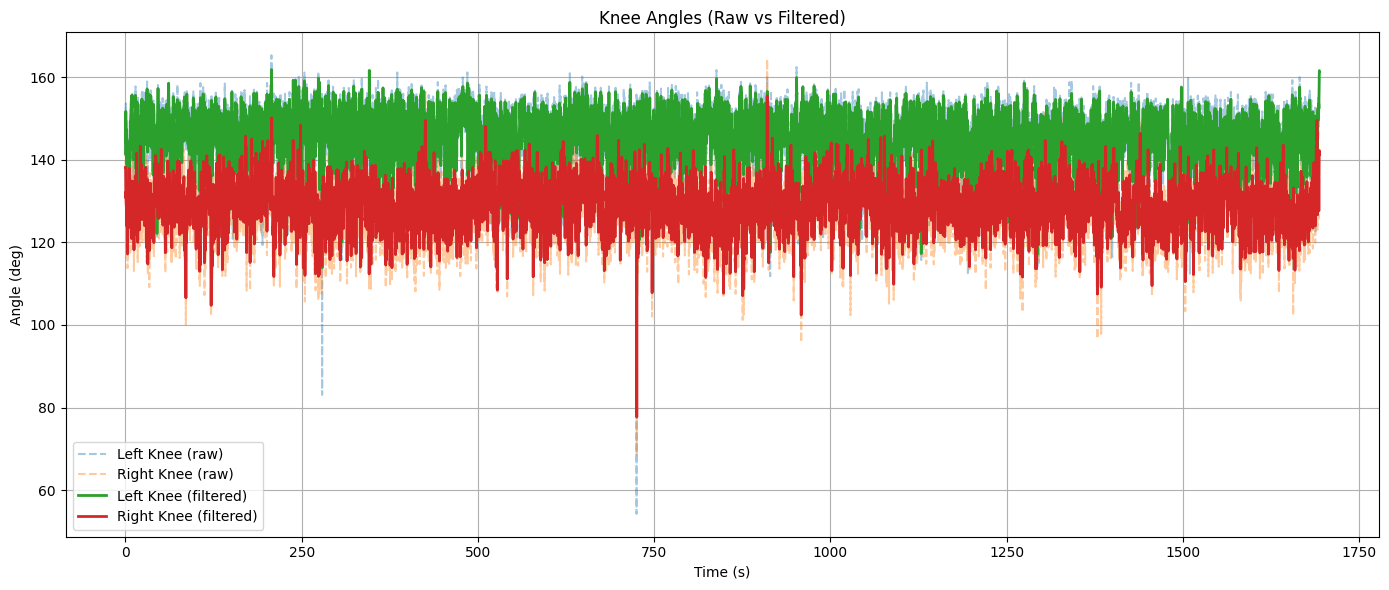

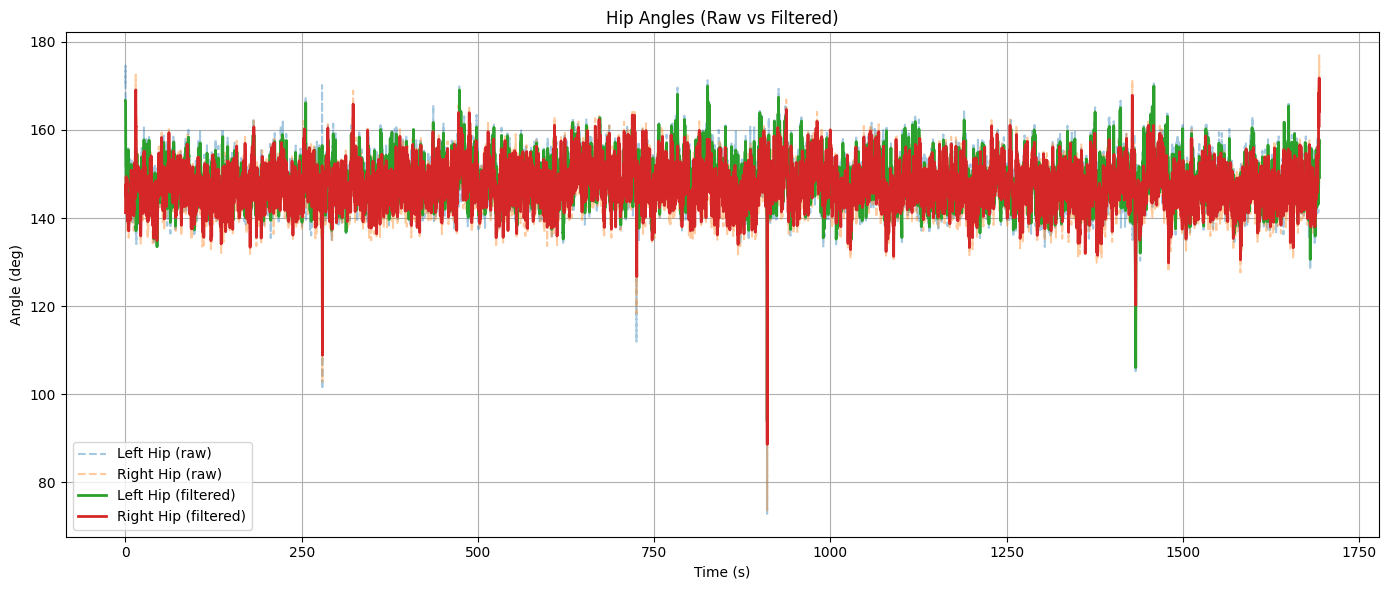

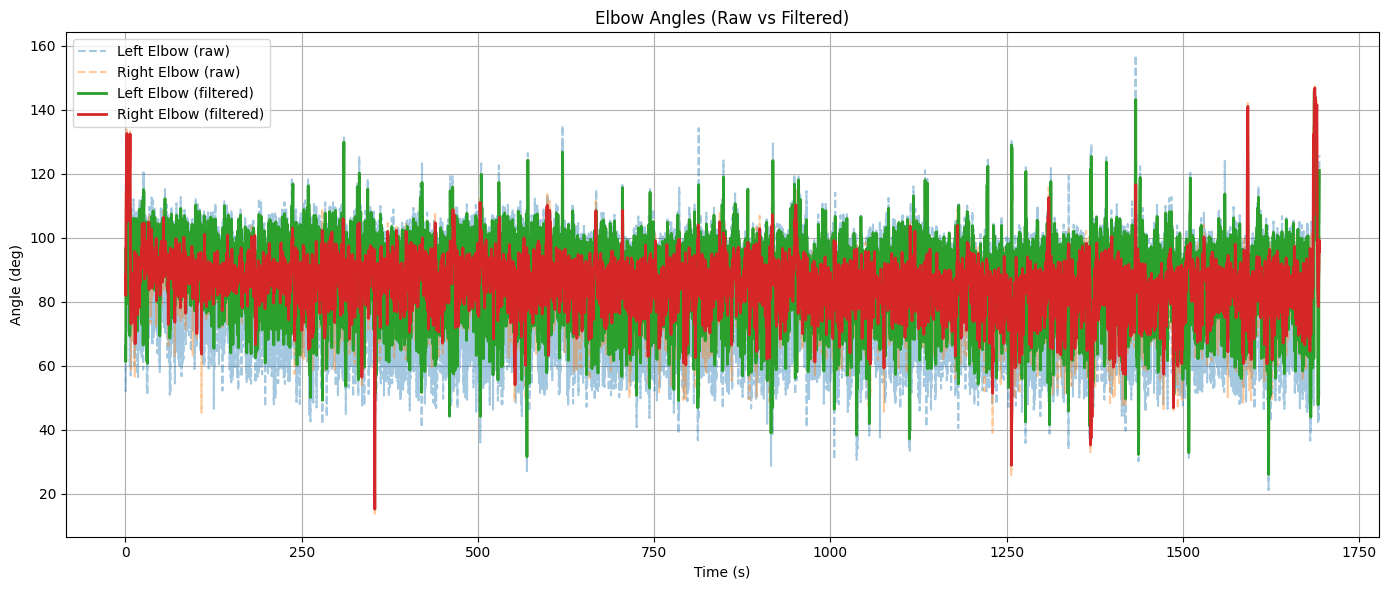

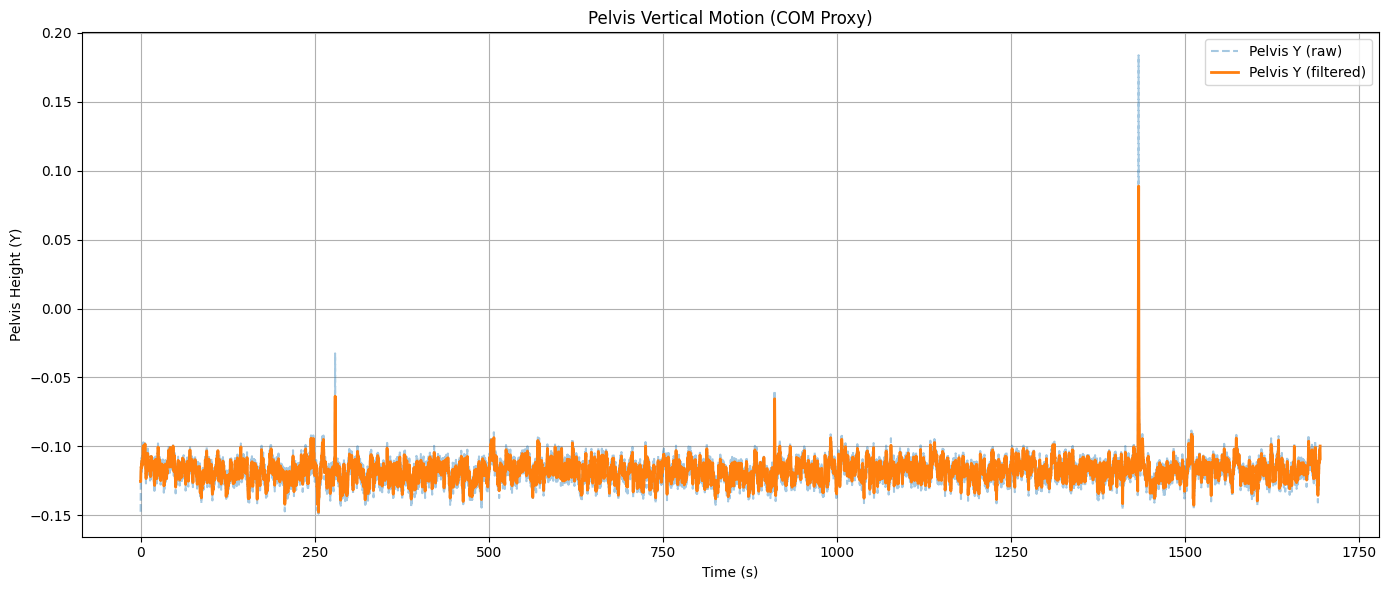

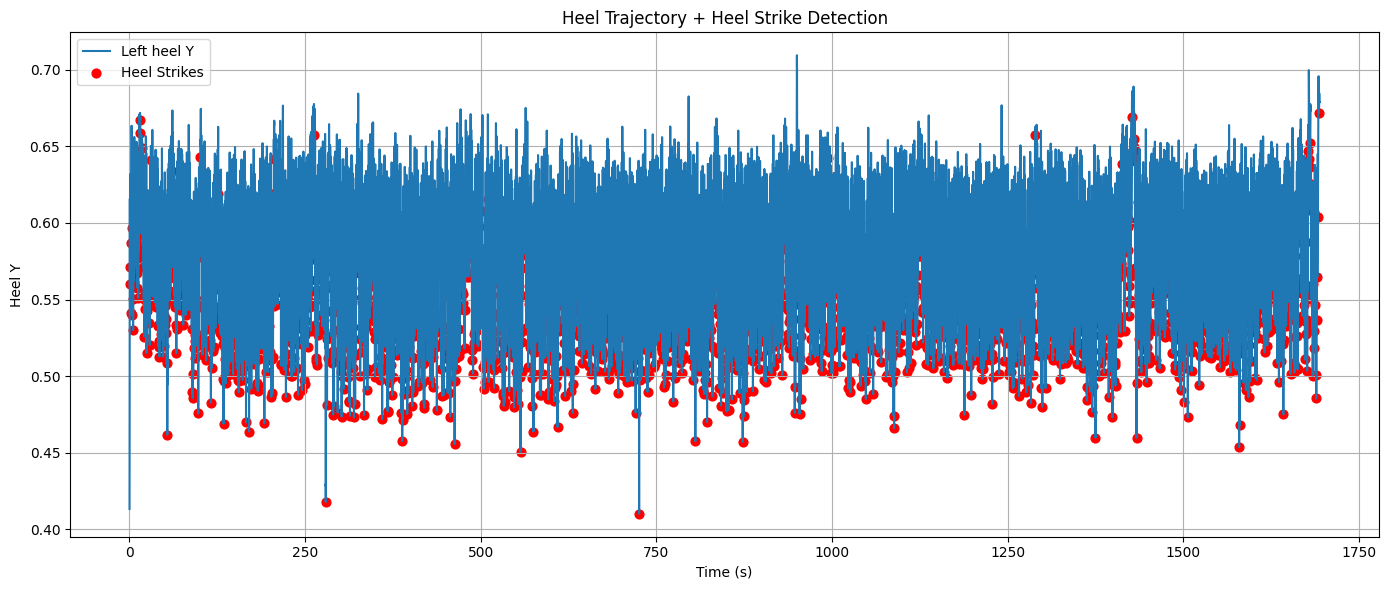


Dashboard generation complete.


In [9]:
#-------------------------------------------------------------------
# 1. LOAD PREPROCESSED DATA
# -------------------------------------------------------------------
CSV_PATH = "data/preprocessed_reduced_joints.csv"
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)

# Handle validity mask
if "valid" in df.columns:
    df["valid"] = df["valid"].astype(str).str.upper().isin(["TRUE", "1", "T"])
    mask_valid = df["valid"].values
else:
    mask_valid = np.ones(len(df), dtype=bool)

time = df.loc[mask_valid, "time"].to_numpy()
if len(time) < 10:
    raise RuntimeError("Too few valid frames after masking.")

# Estimate FPS
dt = np.diff(time)
median_dt = np.median(dt)
fps_est = 1.0 / median_dt if median_dt > 0 else np.nan
print(f"Estimated FPS: {fps_est:.3f} Hz")

# -------------------------------------------------------------------
# 2. HELPER FUNCTIONS
# -------------------------------------------------------------------
def get_joint(df, j_idx, mask):
    cols = [f"joint_{j_idx}_x", f"joint_{j_idx}_y", f"joint_{j_idx}_z"]
    return df.loc[mask, cols].to_numpy()

def joint_angle(a, b, c):
    """
    Compute angle at joint b for vectors (a-b) and (c-b).
    Returns angle in degrees.
    """
    ba = a - b
    bc = c - b
    nba = np.linalg.norm(ba, axis=1)
    nbc = np.linalg.norm(bc, axis=1)
    eps = 1e-8
    nba = np.where(nba < eps, eps, nba)
    nbc = np.where(nbc < eps, eps, nbc)
    cosang = np.sum(ba * bc, axis=1) / (nba * nbc)
    return np.degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

# -------------------------------------------------------------------
# 3. EXTRACT JOINTS (INCLUDING ELBOWS)
# -------------------------------------------------------------------

# Upper body
L_shoulder = get_joint(df, 11, mask_valid)
R_shoulder = get_joint(df, 12, mask_valid)
L_elbow    = get_joint(df, 13, mask_valid)
R_elbow    = get_joint(df, 14, mask_valid)
L_wrist    = get_joint(df, 15, mask_valid)
R_wrist    = get_joint(df, 16, mask_valid)

# Lower body
L_hip      = get_joint(df, 23, mask_valid)
R_hip      = get_joint(df, 24, mask_valid)
L_knee     = get_joint(df, 25, mask_valid)
R_knee     = get_joint(df, 26, mask_valid)
L_ankle    = get_joint(df, 27, mask_valid)
R_ankle    = get_joint(df, 28, mask_valid)
L_heel     = get_joint(df, 29, mask_valid)
R_heel     = get_joint(df, 30, mask_valid)

# Midpoints
pelvis       = 0.5 * (L_hip + R_hip)
shoulder_mid = 0.5 * (L_shoulder + R_shoulder)

# -------------------------------------------------------------------
# 4. ANGLE CALCULATIONS (RAW)
# -------------------------------------------------------------------

# Knees
L_knee_angle = joint_angle(L_hip, L_knee, L_ankle)
R_knee_angle = joint_angle(R_hip, R_knee, R_ankle)

# Hips
L_hip_angle  = joint_angle(shoulder_mid, L_hip, L_knee)
R_hip_angle  = joint_angle(shoulder_mid, R_hip, R_knee)

# Elbows
L_elbow_angle = joint_angle(L_shoulder, L_elbow, L_wrist)
R_elbow_angle = joint_angle(R_shoulder, R_elbow, R_wrist)

# Pelvis vertical
pelvis_y_raw = pelvis[:, 1]
L_heel_y     = L_heel[:, 1]

# -------------------------------------------------------------------
# 5. FILTERING (median filter)
# -------------------------------------------------------------------
print("Applying filtering...")

L_knee_angle_f = medfilt(L_knee_angle, kernel_size=5)
R_knee_angle_f = medfilt(R_knee_angle, kernel_size=5)

L_hip_angle_f  = medfilt(L_hip_angle,  kernel_size=5)
R_hip_angle_f  = medfilt(R_hip_angle,  kernel_size=5)

L_elbow_angle_f = medfilt(L_elbow_angle, kernel_size=5)
R_elbow_angle_f = medfilt(R_elbow_angle, kernel_size=5)

pelvis_y_f = medfilt(pelvis_y_raw, kernel_size=5)

print("Filtering complete.")

# -------------------------------------------------------------------
# 6. HEEL STRIKE DETECTION (Left heel)
# -------------------------------------------------------------------
inv_sig = -L_heel_y
min_distance_frames = int(0.4 * fps_est)
if min_distance_frames < 1:
    min_distance_frames = 1

peaks_idx, _ = find_peaks(inv_sig, distance=min_distance_frames, prominence=0.001)
heel_strike_times = time[peaks_idx]

print(f"Detected {len(peaks_idx)} heel strikes.")

# -------------------------------------------------------------------
# 7. VISUALIZATION (RAW vs FILTERED)
# -------------------------------------------------------------------

# --- Knee angles ---
plt.figure(figsize=(14,6))
plt.plot(time, L_knee_angle, "--", alpha=0.4, label="Left Knee (raw)")
plt.plot(time, R_knee_angle, "--", alpha=0.4, label="Right Knee (raw)")
plt.plot(time, L_knee_angle_f, label="Left Knee (filtered)", linewidth=2)
plt.plot(time, R_knee_angle_f, label="Right Knee (filtered)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Knee Angles (Raw vs Filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --- Hip angles ---
plt.figure(figsize=(14,6))
plt.plot(time, L_hip_angle, "--", alpha=0.4, label="Left Hip (raw)")
plt.plot(time, R_hip_angle, "--", alpha=0.4, label="Right Hip (raw)")
plt.plot(time, L_hip_angle_f, label="Left Hip (filtered)", linewidth=2)
plt.plot(time, R_hip_angle_f, label="Right Hip (filtered)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Hip Angles (Raw vs Filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --- Elbow angles ---
plt.figure(figsize=(14,6))
plt.plot(time, L_elbow_angle, "--", alpha=0.4, label="Left Elbow (raw)")
plt.plot(time, R_elbow_angle, "--", alpha=0.4, label="Right Elbow (raw)")
plt.plot(time, L_elbow_angle_f, label="Left Elbow (filtered)", linewidth=2)
plt.plot(time, R_elbow_angle_f, label="Right Elbow (filtered)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Elbow Angles (Raw vs Filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --- Pelvis COM ---
plt.figure(figsize=(14,6))
plt.plot(time, pelvis_y_raw, "--", alpha=0.4, label="Pelvis Y (raw)")
plt.plot(time, pelvis_y_f, label="Pelvis Y (filtered)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Pelvis Height (Y)")
plt.title("Pelvis Vertical Motion (COM Proxy)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# --- Heel Strikes ---
plt.figure(figsize=(14,6))
plt.plot(time, L_heel_y, label="Left heel Y")
plt.scatter(time[peaks_idx], L_heel_y[peaks_idx], color="red", s=40, label="Heel Strikes")
plt.xlabel("Time (s)")
plt.ylabel("Heel Y")
plt.title("Heel Trajectory + Heel Strike Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

print("\nDashboard generation complete.")


## Feature Extraction

In [10]:
# ------------------------------------------------------------
# 1. Utility Functions
# ------------------------------------------------------------

def segment_strides(time, heel_strike_idx):
    """
    Convert heel-strike indices into stride intervals.
    Each stride = from heel strike i to heel strike i+1.
    """
    segments = []
    for i in range(len(heel_strike_idx) - 1):
        s = heel_strike_idx[i]
        e = heel_strike_idx[i+1]
        if e > s:
            segments.append((s, e))
    return segments


def rom(signal):
    """Range of motion (max - min), safely."""
    if len(signal) < 2:
        return np.nan
    return float(np.nanmax(signal) - np.nanmin(signal))


# ------------------------------------------------------------
# 2. Main Feature Extraction
# ------------------------------------------------------------

def extract_features_per_stride(
    time,
    pelvis_y,
    L_knee_angle,
    R_knee_angle,
    L_hip_angle,
    R_hip_angle,
    L_elbow_angle=None,
    R_elbow_angle=None,
    heel_strike_idx=None
):
    """
    Compute biomechanical stride features.

    INPUTS:
        time              : timestamps
        pelvis_y          : vertical COM proxy
        L_knee_angle      : filtered left knee angle
        R_knee_angle      : filtered right knee angle
        L_hip_angle       : filtered left hip angle
        R_hip_angle       : filtered right hip angle
        L_elbow_angle     : (optional)
        R_elbow_angle     : (optional)
        heel_strike_idx   : indices of heel strikes

    OUTPUT:
        DataFrame of stride features
    """

    if heel_strike_idx is None or len(heel_strike_idx) < 2:
        raise RuntimeError("Not enough heel strikes to compute stride features.")

    segments = segment_strides(time, heel_strike_idx)
    rows = []

    for (s, e) in segments:
        # Duration check
        t0, t1 = float(time[s]), float(time[e])
        stride_duration = t1 - t0

        if stride_duration <= 0 or stride_duration > 3:  # safeguard
            continue

        # Slice signals
        Lk = L_knee_angle[s:e]
        Rk = R_knee_angle[s:e]
        Lh = L_hip_angle[s:e]
        Rh = R_hip_angle[s:e]
        py = pelvis_y[s:e]

        # Optional elbows
        if L_elbow_angle is not None:
            Le = L_elbow_angle[s:e]
            Re = R_elbow_angle[s:e]
        else:
            Le = Re = None

        # Compute ROM values
        Lk_rom = rom(Lk)
        Rk_rom = rom(Rk)
        Lh_rom = rom(Lh)
        Rh_rom = rom(Rh)
        pelvis_range = rom(py)

        # Elbow ROM if provided
        if Le is not None:
            Le_rom = rom(Le)
            Re_rom = rom(Re)
        else:
            Le_rom = Re_rom = np.nan

        # Symmetry
        knee_sym = np.nan
        if Rk_rom > 1e-6:
            knee_sym = Lk_rom / Rk_rom

        row = {
            # Timing
            "stride_start_time": t0,
            "stride_end_time": t1,
            "stride_duration": stride_duration,
            "cadence_spm_equiv": 120.0 / stride_duration,  

            # Knee metrics
            "L_knee_peak_flex": float(np.nanmax(Lk)),
            "L_knee_peak_ext":  float(np.nanmin(Lk)),
            "L_knee_ROM":       float(Lk_rom),

            "R_knee_peak_flex": float(np.nanmax(Rk)),
            "R_knee_peak_ext":  float(np.nanmin(Rk)),
            "R_knee_ROM":       float(Rk_rom),

            # Hip metrics
            "L_hip_ROM": float(Lh_rom),
            "R_hip_ROM": float(Rh_rom),

            # Elbow metrics (optional)
            "L_elbow_ROM": float(Le_rom),
            "R_elbow_ROM": float(Re_rom),

            # Pelvis stability
            "pelvis_vert_range": float(pelvis_range),
            "pelvis_vert_std": float(np.nanstd(py)),

            # Symmetry
            "knee_ROM_sym": float(knee_sym),
        }

        rows.append(row)

    return pd.DataFrame(rows)


# ------------------------------------------------------------
# 3. Run Feature Extraction
# ------------------------------------------------------------

features = extract_features_per_stride(
    time=time,
    pelvis_y=pelvis_y_f,              # use filtered COM
    L_knee_angle=L_knee_angle_f,
    R_knee_angle=R_knee_angle_f,
    L_hip_angle=L_hip_angle_f,
    R_hip_angle=R_hip_angle_f,
    L_elbow_angle=L_elbow_angle_f,    # now included
    R_elbow_angle=R_elbow_angle_f,
    heel_strike_idx=peaks_idx
)

print(features.head())
features.to_csv("data/gait_features.csv", index=False)
print("\nSaved → data/gait_features.csv")


   stride_start_time  stride_end_time  stride_duration  cadence_spm_equiv  \
0           0.666667         1.400000         0.733333         163.636364   
1           1.400000         2.066667         0.666667         180.000000   
2           2.066667         2.533333         0.466667         257.142857   
3           2.533333         3.266667         0.733333         163.636364   
4           3.266667         3.933333         0.666667         180.000000   

   L_knee_peak_flex  L_knee_peak_ext  L_knee_ROM  R_knee_peak_flex  \
0        146.823441       144.003517    2.819924        132.263021   
1        147.307977       138.871538    8.436439        131.805993   
2        144.613791       138.871538    5.742253        130.304708   
3        140.927521       137.840916    3.086605        128.304094   
4        143.272096       141.173299    2.098797        132.898998   

   R_knee_peak_ext  R_knee_ROM  L_hip_ROM  R_hip_ROM  L_elbow_ROM  \
0       128.943112    3.319910   7.534947   4.3

## Unsupervised ML - Isolation Forest
### For anomaly detection


Anomaly label counts:
anomaly
 1    2188
-1      68
Name: count, dtype: int64


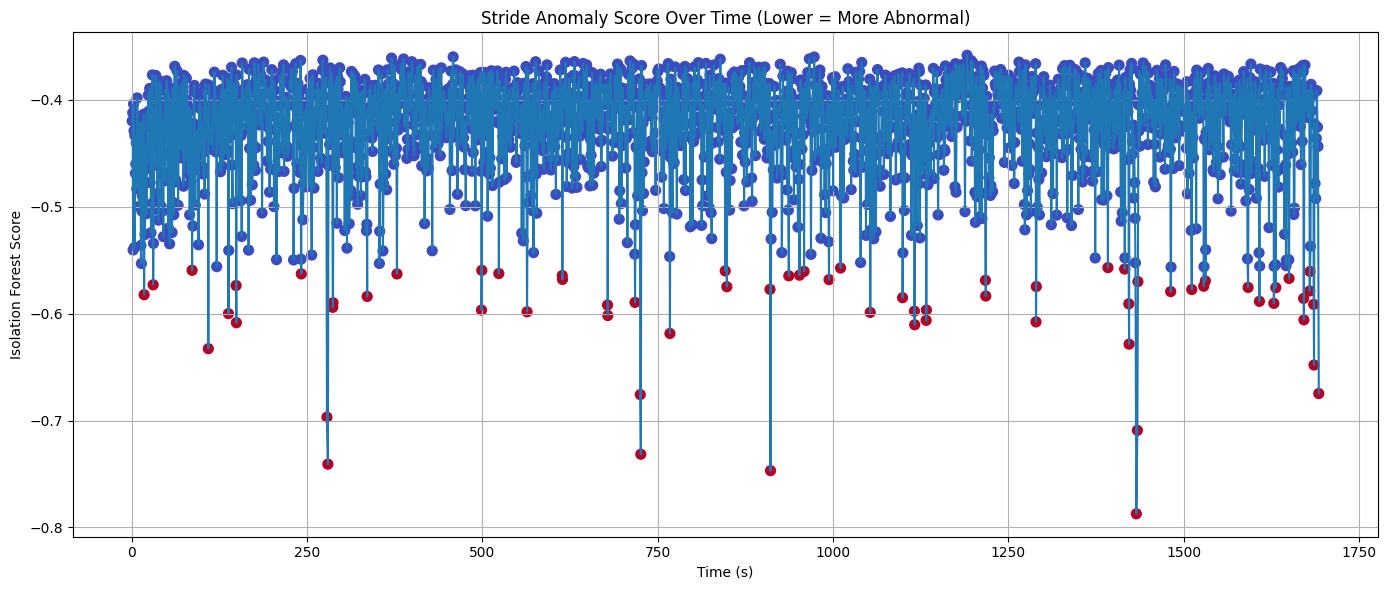

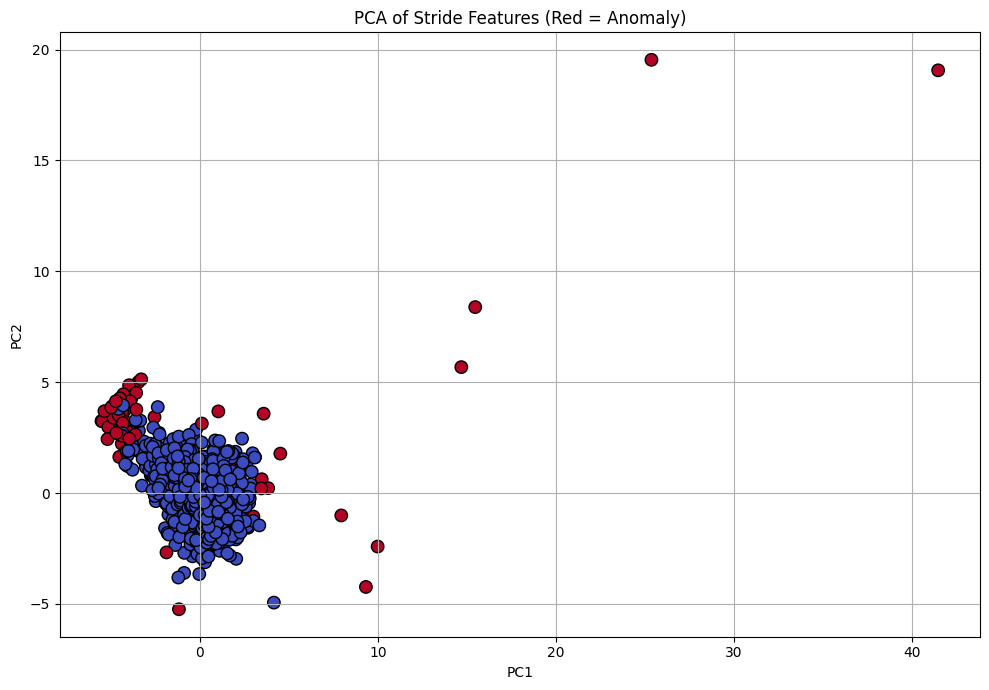

In [12]:
# ------------------------------------------------------------
# 1. Select input features
# ------------------------------------------------------------

feature_cols = [
    "stride_duration",
    "cadence_spm_equiv",
    "L_knee_ROM",
    "R_knee_ROM",
    "L_hip_ROM",
    "R_hip_ROM",
    "pelvis_vert_range",
    "pelvis_vert_std",
    "knee_ROM_sym",
]

if not set(feature_cols).issubset(features.columns):
    missing = set(feature_cols) - set(features.columns)
    raise RuntimeError(f"Missing required feature columns: {missing}")

X = features[feature_cols].copy()

# ------------------------------------------------------------
# 2. Clean feature matrix
# ------------------------------------------------------------

# Replace inf with NaN, then fill using median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Handle constant columns (variance = 0)
for col in X.columns:
    if X[col].std() == 0:
        print(f"[Warning] Column '{col}' has zero variance → dropping.")
        X = X.drop(columns=[col])
        feature_cols.remove(col)

# ------------------------------------------------------------
# 3. Run Isolation Forest
# ------------------------------------------------------------

iso = IsolationForest(
    n_estimators=400,
    contamination=0.03,
    random_state=42,
)

iso.fit(X)

# Predictions: 1 = normal, -1 = anomaly
features["anomaly"] = iso.predict(X)
features["anomaly_score"] = iso.score_samples(X)

print("\nAnomaly label counts:")
print(features["anomaly"].value_counts())

# ------------------------------------------------------------
# 4. Plot anomaly score over time
# ------------------------------------------------------------

# Use stride midpoint for cleaner temporal visualization
stride_mid = (features["stride_start_time"] + features["stride_end_time"]) / 2

plt.figure(figsize=(14, 6))
plt.plot(stride_mid, features["anomaly_score"], label="Anomaly score")
plt.scatter(stride_mid, features["anomaly_score"],
            c=(features["anomaly"] == -1),
            cmap="coolwarm",
            s=50)
plt.title("Stride Anomaly Score Over Time (Lower = More Abnormal)")
plt.xlabel("Time (s)")
plt.ylabel("Isolation Forest Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5. PCA visualization
# ------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(
    pc[:, 0],
    pc[:, 1],
    c=(features["anomaly"] == -1),
    cmap="coolwarm",
    s=80,
    edgecolor='k'
)
plt.title("PCA of Stride Features (Red = Anomaly)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


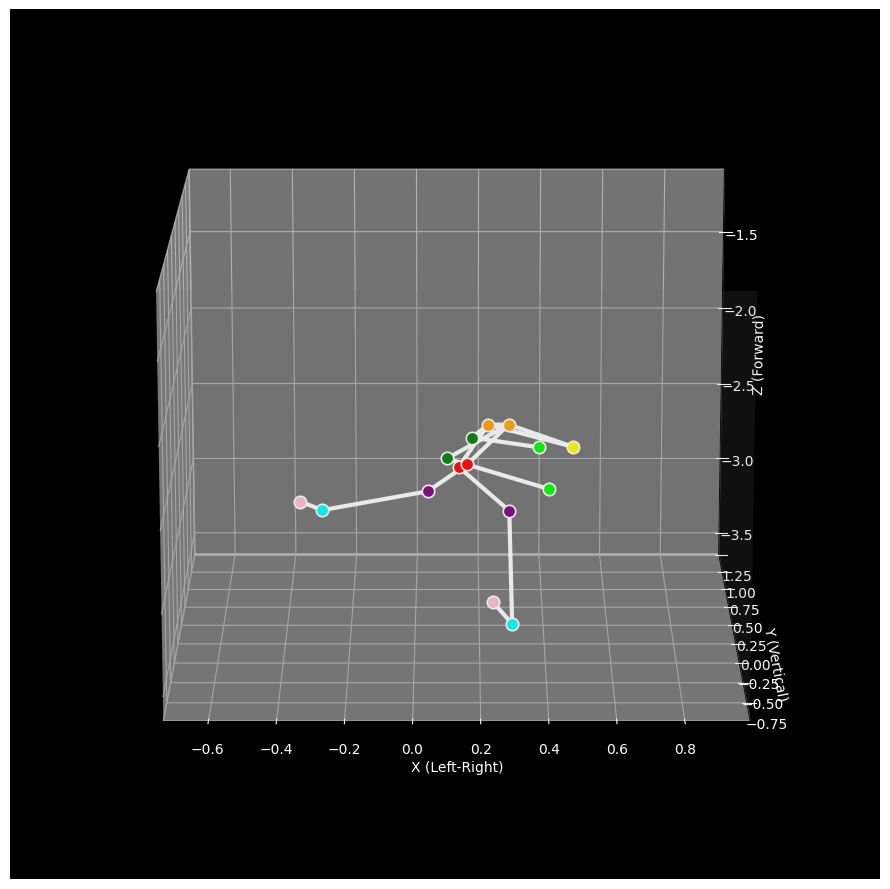

interactive(children=(IntSlider(value=0, description='Frame', max=25270), Output()), _dom_classes=('widget-int…

<function __main__.plot_frame(frame_idx)>

In [18]:
# --------------------------------------------------------
# Load preprocessed data
# --------------------------------------------------------
df = pd.read_csv("data/preprocessed_reduced_joints.csv")
df["valid"] = df["valid"].astype(str).str.upper().isin(["TRUE","1","T"])
df = df[df["valid"]].reset_index(drop=True)

# --------------------------------------------------------
# Keep meaningful joints ONLY
# --------------------------------------------------------
JOINTS = [
    0,      # nose
    11,12,  # shoulders
    13,14,  # elbows (added!)
    15,16,  # wrists
    23,24,  # hips
    25,26,  # knees
    27,28,  # ankles
    29,30   # heels
]

# Load coordinates for those joints
coords = {
    j: df[[f"joint_{j}_x", f"joint_{j}_y", f"joint_{j}_z"]].to_numpy()
    for j in JOINTS
}

# --------------------------------------------------------
# MediaPipe → Real-world transform
# --------------------------------------------------------
def mp_to_world(arr):
    """
    Convert MediaPipe coordinates to biomechanical 3D space:

    MP axes:
        x = left-right (OK)
        y = *down* (invert)
        z = *toward camera* (invert)

    World axes:
        X = left-right
        Y = vertical (up)
        Z = forward (running direction)
    """
    X = arr[:,0]
    Y = -arr[:,1]
    Z = -arr[:,2]
    return np.column_stack((X, Y, Z))

world_coords = {j: mp_to_world(coords[j]) for j in JOINTS}

# --------------------------------------------------------
# Skeleton connections
# --------------------------------------------------------
CONNECTIONS = [
    (0,11), (0,12),
    (11,12),

    (11,13), (13,15),   # left arm
    (12,14), (14,16),   # right arm

    (11,23), (12,24),
    (23,24),

    (23,25), (25,27), (27,29),   # left leg
    (24,26), (26,28), (28,30)    # right leg
]

# --------------------------------------------------------
# Colors for each joint
# --------------------------------------------------------
JOINT_COLOR = {
    0: "yellow",
    11: "orange", 12: "orange",
    13: "green",  14: "green",
    15: "lime",   16: "lime",
    23: "red",    24: "red",
    25: "purple", 26: "purple",
    27: "cyan",   28: "cyan",
    29: "pink",   30: "pink"
}

# --------------------------------------------------------
# Compute global bounds
# --------------------------------------------------------
all_pts = np.vstack([world_coords[j] for j in JOINTS])

xmin, xmax = all_pts[:,0].min(), all_pts[:,0].max()
ymin, ymax = all_pts[:,1].min(), all_pts[:,1].max()
zmin, zmax = all_pts[:,2].min(), all_pts[:,2].max()

pad = 0.15
xr, yr, zr = xmax-xmin, ymax-ymin, zmax-zmin

xmin -= xr*pad; xmax += xr*pad
ymin -= yr*pad; ymax += yr*pad
zmin -= zr*pad; zmax += zr*pad

ground_y = ymin + 0.02

# --------------------------------------------------------
# Styling
# --------------------------------------------------------
def style_axes(ax):
    ax.set_facecolor("black")
    ax.grid(True, color="white", alpha=0.15)
    ax.tick_params(colors="white", labelsize=10)

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.label.set_color("white")

# --------------------------------------------------------
# Frame drawing function
# --------------------------------------------------------
def plot_frame(frame_idx):
    fig = plt.figure(figsize=(11,9))
    ax = fig.add_subplot(111, projection="3d")
    style_axes(ax)

    # Ground plane
    xx, zz = np.meshgrid(
        np.linspace(xmin, xmax, 2),
        np.linspace(zmin, zmax, 2)
    )
    yy = np.full_like(xx, ground_y)
    ax.plot_surface(xx, yy, zz, color="gray", alpha=0.15)

    # Joints
    for j in JOINTS:
        X, Y, Z = world_coords[j][frame_idx]

        ax.scatter(X, Y, Z,
                   s=80,
                   c=JOINT_COLOR[j],
                   edgecolor="white",
                   linewidth=1.2)

    # Lines
    for a, b in CONNECTIONS:
        Xa, Ya, Za = world_coords[a][frame_idx]
        Xb, Yb, Zb = world_coords[b][frame_idx]

        ax.plot([Xa, Xb], [Ya, Yb], [Za, Zb],
                c="white", linewidth=3)

    # Bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)

    ax.set_xlabel("X (Left-Right)")
    ax.set_ylabel("Y (Vertical)")
    ax.set_zlabel("Z (Forward)")

    # Perfect side view
    ax.view_init(elev=15, azim=-90)

    plt.tight_layout()
    plt.show()

# --------------------------------------------------------
# Slider GUI
# --------------------------------------------------------
slider = widgets.IntSlider(
    min=0,
    max=len(df)-1,
    step=1,
    value=0,
    description="Frame"
)

widgets.interact(plot_frame, frame_idx=slider)
